This notebook is an example notebook for processing VAMPIRES polarimetric imaging frames using the pyMuellerMat package to create a system Mueller matrix

In [3]:
from pyMuellerMat import common_mms as cmm
from pyMuellerMat import MuellerMat
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

## Let's build up a perfect Mueller Matrix

First some instrument offset terms

Now all the individual Mueller matrix components. For now we assume that we can remove the instrumental polarization in the data afterwards and that all the other components are ideal

In [4]:
wavelength = 675 #Wavelength in Question
wavelength0 = 700 #Design wavelength

wollaston = cmm.WollastonPrism()

flc = cmm.Retarder(name = "flc") 
flc.properties['phi'] = 2*np.pi*0.5 #Pick your FLC retardance here. ##FREE PARAMETER
flc.properties['theta'] = 0. ##FREE PARAMETER

optics = cmm.DiattenuatorRetarder(name="Periscope") # QWPs are in here too. 
optics.properties['theta'] = 0 ##FREE PARAMETER
optics.properties['epsilon'] = 0 ##FREE PARAMETER
optics.properties['phi'] = 0 ##FREE PARAMETER

image_rotator = cmm.Retarder(name ="image_rotator")
image_rotator.properties['phi'] = 2*np.pi*0.31 #Pick your IMR Retardnace Here ##FREE PARAMETER

hwp = cmm.Retarder(name='hwp') 
hwp.properties['phi'] = 2*np.pi*0.43 #Make the HWP an ideal HWP ##FREE PARAMETER


In [5]:
optics.__dict__

{'name': 'Periscope',
 'function': <function pyMuellerMat.common_mm_functions.diattenuator_retarder_function(epsilon=1, phi=0.0)>,
 'property_list': ['theta', 'epsilon', 'phi'],
 'property_defaults': [0.0, 1, 0.0],
 'default_property_dict': {'theta': 0.0, 'epsilon': 1, 'phi': 0.0},
 'properties': {'theta': 0.0, 'epsilon': 1, 'phi': 0.0},
 'mm': array([[ 1.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0., -0.,  0.]]),
 'default_mm': array([[ 1.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0., -0.,  0.]])}

Combine all the individual components into a system 

In [41]:
sys_mm = MuellerMat.SystemMuellerMatrix([wollaston,flc,optics,image_rotator,hwp])

Build the Measurement Matrix - (i.e. how the sky Stokes vectors relates to the measured intensisty at the detector for any given configuration)

In [42]:
intensities = np.zeros([2,2,8,8]) #Dimensions [n_cameras,n_flc,n_hwp,n_imrot_angs]

hwp_offset = 0 ## FREE PARAMETER
imrot_offset = 0 ##FREE PARAMETER

hwp_angles = np.linspace(0,90,8)+hwp_offset #Put the Real hwp_angles here
imrot_angs = np.linspace(45,135,8)+imrot_offset #Put the Real imrot_angs here

input_q = 0. ##FREE PARAMETER
input_u = 0. ##FREE PARAMETER
input_stokes = np.array([1,input_q,input_u,0])

em_gain_ratio = 0.5 #Cam1/Cam2 ##FREE PARAMETER

for i in range(len(hwp_angles)):
    for j in range(len(imrot_angs)):
        sys_mm.master_property_dict['hwp']['theta'] = hwp_angles[i]
        sys_mm.master_property_dict['image_rotator']['theta'] = imrot_angs[j]

        #Cam 1, FLC 1
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
        sys_mm.master_property_dict['flc']['theta'] = 0
        # print(sys_mm.evaluate())
        intensities[0,0,i,j] = em_gain_ratio*np.matmul(sys_mm.evaluate(),input_stokes)[0]

        #Cam 1, FLC 2
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
        sys_mm.master_property_dict['flc']['theta'] = 45
        # print(sys_mm.evaluate())
        intensities[0,1,i,j] = em_gain_ratio*np.matmul(sys_mm.evaluate(),input_stokes)[0]

        #Cam 2, FLC 1
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
        sys_mm.master_property_dict['flc']['theta'] = 0
        # print(sys_mm.evaluate())
        intensities[1,0,i,j] = np.matmul(sys_mm.evaluate(),input_stokes)[0]

        #Cam 2, FLC 2
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
        sys_mm.master_property_dict['flc']['theta'] = 45
        # print(sys_mm.evaluate())
        intensities[1,1,i,j] = np.matmul(sys_mm.evaluate(),input_stokes)[0]


In [43]:
single_diffs  = intensities[0] - intensities[1]
single_sums = intensities[0] + intensities[1]

double_diff = (single_diffs[0] - single_diffs[1])/(single_sums[0]+single_sums[1])

double_sum = (single_diffs[0] + single_diffs[1])/(single_sums[0]+single_sums[1])


/tmp/ipykernel_373535/1690354270.py:4: RuntimeWarning: invalid value encountered in true_divide
  double_diff = (single_diffs[0] - single_diffs[1])/(single_sums[0]+single_sums[1])
/tmp/ipykernel_373535/1690354270.py:6: RuntimeWarning: invalid value encountered in true_divide
  double_sum = (single_diffs[0] + single_diffs[1])/(single_sums[0]+single_sums[1])


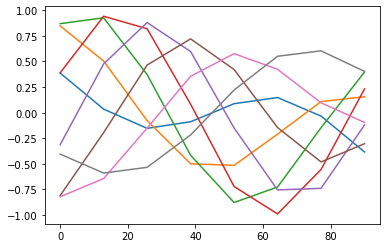

In [44]:
for i in range(len(imrot_angs)):
    plt.plot(hwp_angles,double_diff[:,i])


Text(0, 0.5, 'Double Sum')

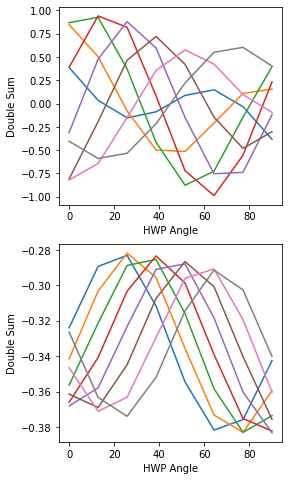

In [45]:
fig,axes = plt.subplots(2,1,figsize=(4,8))

for i in range(len(imrot_angs)):
    axes[0].plot(hwp_angles,double_diff[:,i],)
    axes[1].plot(hwp_angles,double_sum[:,i],label="imrot_angle = {:.0f}".format(imrot_angs[i]))

# axes[1].legend()
axes[0].set_xlabel("HWP Angle")
axes[0].set_ylabel("Double Sum")

axes[1].set_xlabel("HWP Angle")
axes[1].set_ylabel("Double Sum")